In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


#QUESTION

Do people with a higher BMI pay more in health care costs?

Body Mass Index (BMI) is a person's weight in kilograms divided by the square of height in meters. A high BMI can indicate high body fatness. BMI screens for weight categories that may lead to health problems, but it does not diagnose the body fatness or health of an individual.

Considering this, it would be of interest to note the correlation between the BMI metric and how it associates with expendeture on health related services. 

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Pauline177/DataScience2500/main/insurance.csv")

Check the Packaging

In [ ]:
df.shape

(1338, 7)

Check the Top and Bottom of the Dataset

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


Check the n's

Should only have Males/Females with a relatively similar distribution of each.

In [ ]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

Regions should all sum to similar amounts

In [ ]:
northeast_region_df = df[df['region'] == "northeast"]
northwest_region_df = df[df['region'] == "northwest"]
southeast_region_df = df[df['region'] == "southeast"]
southwest_region_df = df[df['region'] == "southwest"]
print("Northeast Sum: " '${0:,}'.format(northeast_region_df['charges'].sum()))
print("Northwest Sum: " '${0:,}'.format(northwest_region_df['charges'].sum()))
print("Southeast Sum: " '${0:,}'.format(southeast_region_df['charges'].sum()))
print("Southwest Sum: " '${0:,}'.format(southwest_region_df['charges'].sum()))

Northeast Sum: $4,343,668.583309
Northwest Sum: $4,035,711.9965399997
Southeast Sum: $5,363,689.763289999
Southwest Sum: $4,012,754.6476200004


Southeast's total is an outlier, let's see why

In [ ]:
print("Northeast: ") 
print(northeast_region_df.shape)
print("Northwest: ") 
print(northwest_region_df.shape)
print("Southeast: ") 
print(southeast_region_df.shape)
print("Southwest: ") 
print(southwest_region_df.shape)

Northeast: 
(324, 7)
Northwest: 
(325, 7)
Southeast: 
(364, 7)
Southwest: 
(325, 7)


Southeast's higher sum appears to be due to a higher number of entries compared to the other regions. Let's make sure there's nothing else dramitically different between the four geographies. We'll do this by performing an analysis of variance (ANOVA) test on each region with relation to healthcare expense. 

By default, we hope that the group means are equal (null hypothesis), as this would better support the idea that any price fluctuations in healthcare costs are not bound to the region in which the healhcare services were performed. 

The other outcome we could see is at least one of the group means is different from the other groups (alternate hypothesis). This would show us that region data with respect to price cannot be discarded. 

If we can remove this correlation, further tests on the data could better support our hypothesis that BMI causes higher healthcare costs. Otherwise we'll have to take region into account of any further analysis. 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


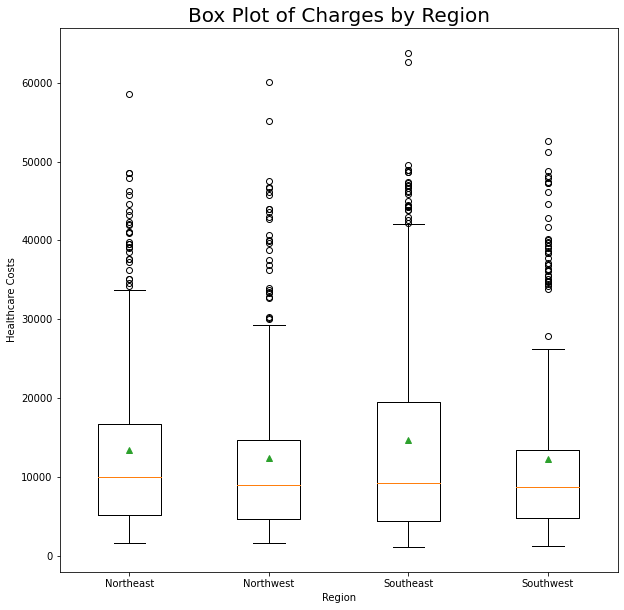

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [ ]:
data = [df['charges'][df['region'] == 'northeast'], 
        df['charges'][df['region'] == 'northwest'], 
        df['charges'][df['region'] == 'southeast'],
        df['charges'][df['region'] == 'southwest']]

#Data is independent and population is large enough to assume normality
#Check variance homogeneity

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()

ax.set_title("Box Plot of Charges by Region", fontsize = 20)
ax.set

ax.boxplot(data, labels = ['Northeast', 'Northwest', 'Southeast', 'Southwest'],
                            showmeans = True)
plt.xlabel("Region")
plt.ylabel("Healthcare Costs")
plt.show()

stats.levene(df['charges'][df['region'] == 'northeast'], 
             df['charges'][df['region'] == 'northwest'], 
             df['charges'][df['region'] == 'southeast'],
             df['charges'][df['region'] == 'southwest'])

After a quick test of variance homogeneity we could not proceed to the ANOVA test, as the pvalue in our region data is clearly much less than 0.05. This indicates that we do not have equal population variances. 

Southeast remains a strong outlier. Let's repeat our quick homogeneity test without the southeast region.

In [ ]:
stats.levene(df['charges'][df['region'] == 'northeast'], 
             df['charges'][df['region'] == 'northwest'],
             df['charges'][df['region'] == 'southwest'])

LeveneResult(statistic=0.08974628654162699, pvalue=0.9141706733642979)

Performing the test again shows us that the remaining three regions do not have much statistically significant difference in their varability. Let's perform an ANOVA test (now that variance homogeneity has been established) on this dataset without the Southeast. 

In [ ]:
stats.f_oneway(df['charges'][df['region'] == 'northeast'], 
               df['charges'][df['region'] == 'northwest'],
               df['charges'][df['region'] == 'southwest'])

F_onewayResult(statistic=0.8916812777093581, pvalue=0.4103013304067413)

Awesome, our F-statistic shows that there is not much variation between the sample means relative to the variation within the samples. Plus, our PValue remains greater than our alpha of 0.05, providing sufficient evidence to claim there is not much difference between the means of our three regions. 

We can confidently move forward with this modified dataset to try and isolate healthcare costs associated with BMI. 


Our goal is to target a correlation between bmi and healthcare expenses. In order to remain true to scope, we must make ensure we select age groups that correlate to associated expenses among peers (older people commonly get colonoscopies, while the young do not for example). 

For us, we will lean on a federally funded study (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3825015/) that looks at common healthcare risks among the US population. These risks are then broken down into risk categories based on age. Nine age groups were defined with the following ranges: 0–2, 3–5, 6–13, 14–18, 19–33, 34–48, 49–64, 65–78, and 79–98 years. 


With the data we have, we will use the age categories 18-33, 34-48, and 49-65 in an attempt to isolate age-related disease factors that could otherwise adversely affect our BMI correlation to health expenses. 

We will also isolate our categories by sex, as the median BMI values for men are approximately 24.5 kg/m2 and 21.5 kg/m2 for women. (https://pubmed.ncbi.nlm.nih.gov/16189499/)

Here we'll isolate our Non-Smoking Males and Females between the ages of 18-33, 34-48, and 49-65 everywhere but the southeast.

In [ ]:
young_female = (df.loc[(df['sex'] == "female") & (df['smoker'] == "no") & (df['age'] >= 18) & (df['age'] <= 33) & 
               (df['region'] != "southeast")])
young_male = (df.loc[(df['sex'] == "male") & (df['smoker'] == "no") & (df['age'] >= 18) & (df['age'] <= 33) & 
               (df['region'] != "southeast")])

print("Number of Females between 18-33:")
print(young_female.shape)
print("Number of Males between 18-33:")
print(young_male.shape)
print()

middle_female = (df.loc[(df['sex'] == "female") & (df['smoker'] == "no") & (df['age'] >= 34) & (df['age'] <= 48) & 
               (df['region'] != "southeast")])
middle_male = (df.loc[(df['sex'] == "male") & (df['smoker'] == "no") & (df['age'] >= 34) & (df['age'] <= 48) & 
               (df['region'] != "southeast")])

print("Number of Females between 34-48:")
print(middle_female.shape)
print("Number of Males between 34-48:")
print(middle_male.shape)
print()


old_female = (df.loc[(df['sex'] == "female") & (df['smoker'] == "no") & (df['age'] >= 49) & (df['age'] <= 65) & 
               (df['region'] != "southeast")])
old_male = (df.loc[(df['sex'] == "male") & (df['smoker'] == "no") & (df['age'] >= 49) & (df['age'] <= 65) & 
               (df['region'] != "southeast")])

print("Number of Females between 49-65:")
print(old_female.shape)
print("Number of Males between 49-65:")
print(old_male.shape)

Number of Females between 18-33:
(152, 7)
Number of Males between 18-33:
(148, 7)

Number of Females between 34-48:
(119, 7)
Number of Males between 34-48:
(114, 7)

Number of Females between 49-65:
(137, 7)
Number of Males between 49-65:
(121, 7)


##Young People

Among young people, there doesn't seem to be much correlation in BMI and healthcare expenses irrespective of sex. While there is a positive indication, it isn't statistically significant.

In [ ]:
youth_f = young_female.drop(columns = ['children', 'age', 'smoker', 'region', 'sex'])
youth_f.corr().style.background_gradient(cmap = "GnBu")

,bmi,charges
bmi,1.000000,0.036110
charges,0.036110,1.000000


In [ ]:
youth_m = young_male.drop(columns = ['children', 'age', 'smoker', 'region', 'sex'])
youth_m.corr().style.background_gradient(cmap = "GnBu")

,bmi,charges
bmi,1.000000,0.085902
charges,0.085902,1.000000


##Middle-Aged People

Among the middle-aged. Interesting to note, there is a 5x correlation increase of BMI and healthcare expenses among females compared to the young female age group.

For men, the correlation seems to go down as middle age is reached. 

Overall correlation however still remains statistically insignificant.

In [ ]:
middle_f = middle_female.drop(columns = ['children', 'age', 'smoker', 'region', 'sex'])
middle_f.corr().style.background_gradient(cmap = "GnBu")

,bmi,charges
bmi,1.000000,0.179494
charges,0.179494,1.000000


In [ ]:
middle_m = middle_male.drop(columns = ['children', 'age', 'smoker', 'region', 'sex'])
middle_m.corr().style.background_gradient(cmap = "GnBu")

,bmi,charges
bmi,1.000000,0.020289
charges,0.020289,1.000000


##Older People

Among older people BMI correlations to healthcare expenses remain insignificant. Both males and females see their BMI correlations drop from middle to old age.

In [ ]:
old_f = old_female.drop(columns = ['children', 'age', 'smoker', 'region', 'sex'])
old_f.corr().style.background_gradient(cmap = "GnBu")

,bmi,charges
bmi,1.000000,0.068358
charges,0.068358,1.000000


In [ ]:
old_m = old_male.drop(columns = ['children', 'age', 'smoker', 'region', 'sex'])
old_m.corr().style.background_gradient(cmap = "GnBu")

,bmi,charges
bmi,1.000000,0.082945
charges,0.082945,1.000000


#Summary

In choosing the Health Insurance Costs dataset I wanted to know if we could find some correlation between an individuals Body Mass Index (BMI) and their overall expenditure on healthcare. Logic seems to flow that those with a higher BMI (possibly overweight) would presumably be paying quite a bit more in these costs, as it is assumed they are unhealthy and would therefore need more care. 

In order to answer this question, I needed to refine the dataset down a bit to better remove any potential conflict in my correlation. Conflicts that came to mind were region, age, and sex. I also removed smokers. There were roughly an equal amount of females to males. I also inspected the sums of each region to see if the totals were roughly the same - they were not.

Diving into the regions further, I realized the Southeast had nearly 40 additional entries, which made sense considering I just calculated the sum - it should be larger. Ruling that out, I compared the regions with a boxplot (helpful to see what's going on in the data) and calculated their variance homogeneity which showed unequal population variances. From the boxplot it was clear to see that the Southeast region remained an outlier, so I removed it from the dataset and did the test again - this time establishing relatively equal variances among the three remaining regions.

I continued with an analysis of variance test (ANOVA) with the remaining three regions and their association to healthcare costs. The F-Statistic and PValue were not statistically significant, allowing me to press on without worrying that different regions were messing up my BMI - Healthcare Costs correlation.

With regions out of the way, I needed to find good data on diseases and how they manifest with respect to age group. A solid federally funded data source allowed me to break-up my data into age categories, better constraining any healthcare costs from age-related diseases to their respective peer groups. 

I used another federal data source to see if there was any major difference between the average BMI of men and women. There were, so in addition to splitting the data into age groups, I also separated them by sex. 

My groups were now ready to be analyzed with a correlation coefficient between healthcare expenses and BMI. A correlation coefficient is a number between -1 and 1 that tells you the strength and direction of a relationship between variables, in our case those variables are BMI and Healthcare Costs. 

I used a simple correlation matrix with a bit of color for visualizing these relationships. If our correlation is very strong or antithetical for example, the color will become much darker. 

Performing our correlation test over each age group showed us a weak correlation throughout. While it was there and was positive, it was not statistically significant enough to warrant any assumption that a higher BMI definitively increases your liklihood of spending money on healthcare. While it seemed logical to assume, these tests clearly show that is not confidently the case. 

Lane Zaugg


